In [ ]:
!pip install sec-api
!pip install torchinfo
!pip install torchmetrics
!pip install wandb

# <b>1 <span style='color:#9146ff'>|</span> Import Libraries</b>

In [ ]:
import warnings
warnings.filterwarnings('ignore')
import wandb

import torch
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import DataLoader , TensorDataset
from torchinfo import summary
from torchmetrics.text import BLEUScore

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from tqdm.auto import tqdm
import seaborn as sns

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

import re
import ast
from nltk.corpus import stopwords
from collections import Counter
from string import punctuation
from wordcloud import WordCloud

from sec_api import ExtractorApi


In [ ]:
#Reading the JSON File


# Convert to DataFrame
data = pd.read_json('/content/Cleaned_date.json',encoding='utf-8')
df_cleaned = pd.DataFrame(data)

# Drop 'input' and 'text' columns
df_cleaned = df_cleaned.drop(columns=['input', 'text'])

# Display the result
df_cleaned

,instruction,output
0,"For a car, what scams can be plotted with 0% f...",The car deal makes money 3 ways. If you pay in...
1,Why does it matter if a Central Bank has a neg...,"That is kind of the point, one of the hopes is..."
2,Where should I be investing my money?,"Pay off your debt. As you witnessed, no ""inve..."
3,Specifically when do options expire?,"Equity options, at least those traded in the A..."
4,Negative Balance from Automatic Options Exerci...,"Automatic exercisions can be extremely risky, ..."
...,...,...
68907,Generate an example of what a resume should li...,"Jean Tremaine\n1234 Main Street, Anytown, CA 9..."
68908,Arrange the items given below in the order to ...,I eating cake.
68909,Write an introductory paragraph about a famous...,Michelle Obama is an inspirational woman who r...
68910,Generate a list of five things one should keep...,1. Research potential opportunities and carefu...


In [ ]:
'''df_10_k = pd.read_parquet("hf://datasets/itzme091/financial-conversation/data/train-00000-of-00001.parquet")

df_10_k['instruction'] = df_10_k['conversations'].apply(lambda x: x['conversations'][0]['value'].split('Input:\n')[-1].strip())
df_10_k['output'] = df_10_k['conversations'].apply(lambda x: x['conversations'][1]['value'])

df_10_k = df_10_k.drop(columns=['conversations'])

df_10_k.head(10)'''

,instruction,output
0,With respect to NVDA company What area did NVI...,NVIDIA initially focused on PC graphics.
1,With respect to NVDA company What are some of ...,Recent applications of GPU-powered deep learni...
2,With respect to NVDA company What significant ...,NVIDIA invented the GPU in 1999.
3,With respect to NVDA company How does NVIDIA's...,NVIDIA's platform strategy brings together har...
4,With respect to NVDA company What does NVIDIA'...,NVIDIA's CUDA programming model opened the par...
5,With respect to NVDA company What industries u...,NVIDIA's GPUs and software are used for automa...
6,With respect to NVDA company Why did NVIDIA an...,NVIDIA and SoftBank terminated their Share Pur...
7,With respect to NVDA company What amount did N...,NVIDIA recorded an acquisition termination cos...
8,With respect to NVDA company What does the NVI...,The NVIDIA computing platform focuses on accel...
9,With respect to NVDA company What are the key ...,The NVIDIA computing platform includes energy-...


In [ ]:
#frames = [df_10_k,df_cleaned]
#df = pd.concat(frames)
df = df_cleaned
df.head(10)

,instruction,output
0,"For a car, what scams can be plotted with 0% f...",The car deal makes money 3 ways. If you pay in...
1,Why does it matter if a Central Bank has a neg...,"That is kind of the point, one of the hopes is..."
2,Where should I be investing my money?,"Pay off your debt. As you witnessed, no ""inve..."
3,Specifically when do options expire?,"Equity options, at least those traded in the A..."
4,Negative Balance from Automatic Options Exerci...,"Automatic exercisions can be extremely risky, ..."
5,Approximation of equity value for company in d...,"Generally ""default"" means that the company can..."
6,Is it true that 90% of investors lose their mo...,The game is not zero sum. When a friend and I ...
7,Can a company charge you for services never re...,"In general, you can only be charged for servic..."
8,Working out if I should be registered as self-...,Being self employed just means you fill out so...
9,About eToro investments,"For eToro, just like any other brokerage firm,..."


# <b>2 <span style='color:#9146ff'>|</span> Dataset</b>

In [ ]:
DEVICE = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Using {DEVICE} device")

Using cuda device


### Define dataframe

In [ ]:
df['src_len'] = [len(text.split()) for text in df.instruction]
df['trg_len'] = [len(text.split()) for text in df.output]

df

,instruction,output,src_len,trg_len
0,"For a car, what scams can be plotted with 0% f...",The car deal makes money 3 ways. If you pay in...,13,371
1,Why does it matter if a Central Bank has a neg...,"That is kind of the point, one of the hopes is...",16,72
2,Where should I be investing my money?,"Pay off your debt. As you witnessed, no ""inve...",7,69
3,Specifically when do options expire?,"Equity options, at least those traded in the A...",5,60
4,Negative Balance from Automatic Options Exerci...,"Automatic exercisions can be extremely risky, ...",9,527
...,...,...,...,...
68907,Generate an example of what a resume should li...,"Jean Tremaine\n1234 Main Street, Anytown, CA 9...",13,287
68908,Arrange the items given below in the order to ...,I eating cake.,13,3
68909,Write an introductory paragraph about a famous...,Michelle Obama is an inspirational woman who r...,8,91
68910,Generate a list of five things one should keep...,1. Research potential opportunities and carefu...,16,52


# <b>3 <span style='color:#9146ff'>|</span> EDA</b>

### Distribution of Sentences Length

In [ ]:
def distribution_graphic(df,name,title):
       fig = px.histogram(df, x=name)
       fig.update_layout(height=400, title_text=title, showlegend=False)
       fig.show()

distribution_graphic(df['src_len'],'src_len',"Dialog Length Distribution")
distribution_graphic(df['trg_len'],'trg_len',"Answer Length Distribution")

### World Cloud Graphic
The size of each word shows how frequently it appears in the dataset



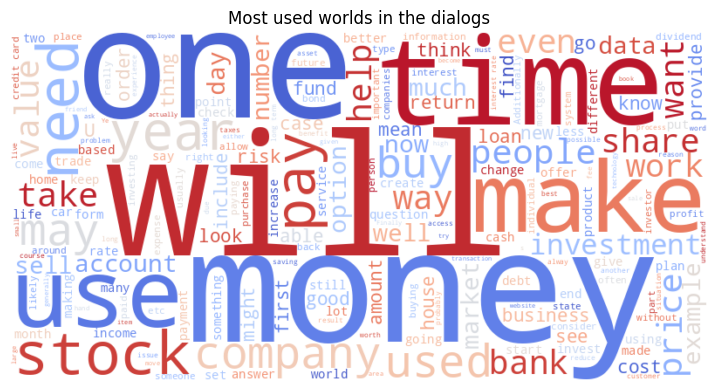

In [ ]:
wordcloud = WordCloud(width=800, height=400, background_color='white',colormap='coolwarm').generate(' '.join(df['output']))

plt.figure(figsize=(9, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Most used worlds in the dialogs")
plt.show()

# <b>4 <span style='color:#9146ff'>|</span> Data processing</b>

### Define functions to treat dialog and answer columns

In [ ]:
def dialog_treatment(df,column):
    df[column] = df[column].astype(str) # Convert all the values of the column to str type
    df[column] = df[column].str.lower() # Transform the string values in lowercase
    df[column] = df[column].apply(lambda x: re.sub("[^A-Za-z\s]","",x)) # Replace any non-alphabetical characters with white space
    df[column] = df[column].apply(lambda x: x.replace("\s+"," ")) # Replace white spaces with a single white space
    df[column] = df[column].apply(lambda x: " ".join([word for word in x.split()])) ###'''
    return df

def answer_treatment(df,column):
    df[column] = df[column].astype(str) # Convert all the values of the column to str type
    df[column] = df[column].str.lower() # Transform the string values in lowercase
    df[column] = df[column].apply(lambda x: re.sub(r'\d','',x))# Remove all numeric characters
    df[column] = df[column].apply(lambda x: x.replace("\s+"," ")) # Replace white spaces with a single white space
    df[column] = df[column].apply(lambda x: re.sub(r"[-()&\"#/@;:<>{}`+=~|.!?,।]", "", x)) # Remove specific punctuation and special characters from the values
    df[column] = df[column].apply(lambda x: x.strip()) # Clean up text data  removing unwanted spaces'''
    df[column] = "<sos> " + df[column] + " <eos>" # Add start of sequence and end of sequence to the string
    return df

### Treat columns

In [ ]:
df = dialog_treatment(df , 'instruction')
df = answer_treatment(df , 'output')

df.head(10)

,instruction,output,src_len,trg_len
0,for a car what scams can be plotted with finan...,<sos> the car deal makes money ways if you pa...,13,371
1,why does it matter if a central bank has a neg...,<sos> that is kind of the point one of the hop...,16,72
2,where should i be investing my money,<sos> pay off your debt as you witnessed no i...,7,69
3,specifically when do options expire,<sos> equity options at least those traded in ...,5,60
4,negative balance from automatic options exerci...,<sos> automatic exercisions can be extremely r...,9,527
5,approximation of equity value for company in d...,<sos> generally default means that the company...,8,123
6,is it true that of investors lose their money,<sos> the game is not zero sum when a friend a...,10,418
7,can a company charge you for services never re...,<sos> in general you can only be charged for s...,11,111
8,working out if i should be registered as selfe...,<sos> being self employed just means you fill ...,12,111
9,about etoro investments,<sos> for etoro just like any other brokerage ...,3,61


### Define the max and minimum length of a sentence in each column

In [ ]:
df_trial = df[~(df['src_len'] < 5) & ~(df['src_len'] > 19)]
df_trial = df[~(df['trg_len'] < 5) & ~(df['trg_len'] > 19)]

df_trial

,instruction,output,src_len,trg_len
99,do i have to pay a capital gains tax if i rebu...,<sos> yes wash rules are only for losses <eos>,18,7
187,buying my first car out of college,<sos> i've seen this approach to buyingfunding...,7,19
242,what is the formula for determining estimated ...,<sos> see this linki was also looking an answe...,18,19
280,what one bit of financial advice do you wish y...,<sos> i wish i would have <eos>,16,5
306,stocks where can i find a list of bankruptdilu...,<sos> the only recommendation i have is to try...,13,16
...,...,...,...,...
68891,convert the sentence he ran quickly to the sto...,<sos> he had run quickly to the store <eos>,14,7
68892,edit the sentence the alarm clock was ringing ...,<sos> the alarm clock blared loudly at seven o...,13,8
68893,delete any words that are redundant in the sen...,<sos> i bought items at the store <eos>,18,6
68897,create a news headline for a story about a cel...,<sos> tom hanks publishes new book exploring '...,15,13


In [ ]:
'''df_trial_2.head(10)
df = df_trial_2
df'''

df = df_trial

df

,instruction,output,src_len,trg_len
99,do i have to pay a capital gains tax if i rebu...,<sos> yes wash rules are only for losses <eos>,18,7
187,buying my first car out of college,<sos> i've seen this approach to buyingfunding...,7,19
242,what is the formula for determining estimated ...,<sos> see this linki was also looking an answe...,18,19
280,what one bit of financial advice do you wish y...,<sos> i wish i would have <eos>,16,5
306,stocks where can i find a list of bankruptdilu...,<sos> the only recommendation i have is to try...,13,16
...,...,...,...,...
68891,convert the sentence he ran quickly to the sto...,<sos> he had run quickly to the store <eos>,14,7
68892,edit the sentence the alarm clock was ringing ...,<sos> the alarm clock blared loudly at seven o...,13,8
68893,delete any words that are redundant in the sen...,<sos> i bought items at the store <eos>,18,6
68897,create a news headline for a story about a cel...,<sos> tom hanks publishes new book exploring '...,15,13


In [ ]:
df.head(100)

,instruction,output,src_len,trg_len
99,do i have to pay a capital gains tax if i rebu...,<sos> yes wash rules are only for losses <eos>,18,7
187,buying my first car out of college,<sos> i've seen this approach to buyingfunding...,7,19
242,what is the formula for determining estimated ...,<sos> see this linki was also looking an answe...,18,19
280,what one bit of financial advice do you wish y...,<sos> i wish i would have <eos>,16,5
306,stocks where can i find a list of bankruptdilu...,<sos> the only recommendation i have is to try...,13,16
...,...,...,...,...
4722,what percent of my salary should i save,<sos> a single percentage figure makes little ...,8,18
4735,is there a good forum where i can discuss indi...,<sos> i use the forum seeking alpha httpseekin...,12,7
4765,repaying debt and saving difficult situation,<sos> i see one clear thing to help she lives ...,7,18
4777,where can publicly traded profits go but to sh...,<sos> where can publicly traded profits go but...,11,18


In [ ]:
src_max_lenght_sentence = np.max(df['src_len'])
trg_max_lenght_sentence = np.max(df['trg_len'])

print(src_max_lenght_sentence)
print(trg_max_lenght_sentence)

51
19


 ## <b>4.1 <span style='color:#9146ff'>|</span> Vectorization </b>

 https://www.geeksforgeeks.org/vectorization-techniques-in-nlp/

 It's the process to convert text data into numerical vectors, that can be understood and processed by ML models

 Traditional Tecniques: Bag of Words (BoW), Term Frequency-Inverse Document Frequency (TF-IDF), and Count Vectorizer.

In [ ]:
def Vectorization(column , max_sequence_lenght):

    sentences = df[column].tolist() # Convert column into list
    words_list = [word for text in df[column] for word in text.split()]  # Split each sentence in worlds
    vocab_size = len(Counter(sentences)) # Verify the lenght of the total of occurences of each world

    # Convert texts into a sequence of integers
    tokenizer = Tokenizer(num_words=vocab_size , oov_token = "<OOV>" ,
                          filters='!#$%&()*+,-/:;<=>@«»""[\\]^_`{|}~\t\n'
                         ) ###

    tokenizer.fit_on_texts(sentences) # Build the vocabulary from a list of sentences
    tokenizer.word_index['<pad>'] = 0 # Add index <pad> with value 0
    tokenizer.index_word[0] = '<pad>' # Add <pad> to index 0

    vocab_to_idx = tokenizer.word_index
    idx_to_vocab = tokenizer.index_word


    sequences = tokenizer.texts_to_sequences(sentences) # Converts sentences into integer sequences
    pad_sequen = pad_sequences(sequences , maxlen = max_sequence_lenght , padding = 'post') # Ensures that all sequences in  are padded to the length MAXLEN. If the sequence is shorter than MAXLEN, it adds 0.
    print(pad_sequen)
    print(tokenizer)

    return pad_sequen, tokenizer

In [ ]:
src_sequences , src_tokenizer = Vectorization('instruction' , src_max_lenght_sentence)
trg_sequences , trg_tokenizer = Vectorization('output' , trg_max_lenght_sentence)

[[   7    3  112 ...    0    0    0]
 [  33   55   22 ...    0    0    0]
 [ 162   45   18 ...    0    0    0]
 ...
 [  28   10 3910 ...    0    0    0]
 [  17    3   21 ...    0    0    0]
 [ 156    2   11 ...    0    0    0]]
[[   10     2   169 ...     0     0     0]
 [   10    12     8 ...     0     0     0]
 [   10    71   148 ...     0     0     0]
 ...
 [   10 21874  7521 ...     0     0     0]
 [   10   435   271 ...     0     0     0]
 [   10    26   727 ...     0     0     0]]


In [ ]:
print("Size of the source vocabulary :",len(src_tokenizer.word_index))
print("Size of the target vocabulary :", len(trg_tokenizer.word_index))

Size of the source vocabulary : 16864
Size of the target vocabulary : 72359


### Verify sequence tokenized

In [ ]:
trg_sent = ' '.join([trg_tokenizer.index_word[idx] for idx in trg_sequences[6] if idx != 0])
print(f"{trg_sequences[6]} \n\n {trg_sent}")

[ 10   2 571 ...   0   0   0] 

 sos the game is not zero sum when a friend and i chop down a tree and build a house from it the house has value far greater than the value of a standing tree our labor has turned into something of value in theory a company starts from an idea and offers either a good or service to create value there are scams that make it seem like a vegas casino there are times a stock will trade for well above what it should when i buy the sp index at a fair price for through an etf or fund and years later it's the gain isn't out of someone else's pocket else the amount of wealth in the world would be fixed and that's not the case over time investors lag the market return for multiple reasons trading costs bad timing etc statements such as lose money are hyperbole meant to separate you from your money a self fulfilling prophesy the question of lagging the market is another story i have no data to support my observation but i'd imagine that well over lag the broad mark

# <b>5 <span style='color:#9146ff'>|</span> Data Pipeline</b>

In [ ]:
batch_size = 128


dataset = TensorDataset(torch.LongTensor(src_sequences) , torch.LongTensor(trg_sequences)) # Converts sequences in Pytoch tensors and create a tensor dataset

torch.manual_seed(42)

dataframe_dataloader = DataLoader(
    dataset = dataset ,
    batch_size = batch_size ,
    shuffle = True ,
    num_workers = 4 ,
    pin_memory = True
)

# <b>6 <span style='color:#9146ff'>|</span> Model Build </b>

## <b>6.1 <span style='color:#9146ff'> Self-Attention</span>  </b>
It let's the model decide how important each part of an input sequence is, which makes it possible to find dependencies and connections in the data.

The model calculates the attention weights between each element in the input sequence, allowing it to focus on the relevant factors.

In [ ]:
def SelfAttention(q , k , v , mask) :

    attention_scores = torch.matmul(q , k.transpose(-2 , -1)).to(DEVICE)  # Matrix multiplication

    scaling = torch.sqrt(torch.tensor(k.size(-1) , dtype = torch.float32)).to(DEVICE) # Computes the square root of dim

    scaled_attention = attention_scores / scaling

    # Apply mask if provided (useful for preventing attention to certain parts like padding)
    if mask is not None:
        scaled_attention += (mask * -1e9)

    # Apply softmax
    attention_weights = torch.softmax(scaled_attention, dim=-1).to(DEVICE)

    # Compute the weighted sum of the value vectors using the attention weights
    output = torch.matmul(attention_weights , v).to(DEVICE)

    return output

In [ ]:
'''def scaled_dot_product_attention(self, Q, K, V, mask=None):
        # Calculate attention scores
        attn_scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(self.d_k)

        # Apply mask if provided (useful for preventing attention to certain parts like padding)
        if mask is not None:
            attn_scores = attn_scores.masked_fill(mask == 0, -1e9)

        # Softmax is applied to obtain attention probabilities
        attn_probs = torch.softmax(attn_scores, dim=-1)

        # Multiply by values to obtain the final output
        output = torch.matmul(attn_probs, V)
        return output'''

'def scaled_dot_product_attention(self, Q, K, V, mask=None):\n        # Calculate attention scores\n        attn_scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(self.d_k)\n        \n        # Apply mask if provided (useful for preventing attention to certain parts like padding)\n        if mask is not None:\n            attn_scores = attn_scores.masked_fill(mask == 0, -1e9)\n        \n        # Softmax is applied to obtain attention probabilities\n        attn_probs = torch.softmax(attn_scores, dim=-1)\n        \n        # Multiply by values to obtain the final output\n        output = torch.matmul(attn_probs, V)\n        return output'

## <b>6.2 <span style='color:#9146ff'> Multi-Head-Attention</span>  </b>

In [ ]:
'''class MultiHeadAttention(nn.Module) :
    def __init__(self , model_dimension , num_heads) :
        super(MultiHeadAttention , self).__init__()

        self.model_dimension = model_dimension
        self.num_heads = num_heads

        # Verify if the model dimension is divisible by num_head
        assert self.model_dimension % self.num_heads == 0

        self.head_dimension = self.model_dimension // self.num_heads # Dimension of each head's key, query, and value

        # Linear layers for input transformations
        self.Q = nn.Linear(model_dimension , model_dimension) # Query
        self.K = nn.Linear(model_dimension , model_dimension) # Key
        self.V = nn.Linear(model_dimension , model_dimension) # Value
        self.output_t = nn.Linear(model_dimension , model_dimension) # Output

    def split_heads(self , x , batch_size) :

        # Change the input to have the num_heads for multi-head attention
        x = x.reshape(batch_size , -1 , self.num_heads , self.head_dimension)
        return x.permute(0, 2, 1, 3)

    def forward(self , q , k , v , mask = None) :
        batch_size = q.shape[0]

        # Apply linear transformations and split heads
        q_transform = self.split_heads(self.Q(q),batch_size)
        k_transform = self.split_heads(self.K(k),batch_size)
        v_transform = self.split_heads(self.V(v),batch_size)

        # Perform scaled dot-product attention
        self_attention = SelfAttention(q_transform , k_transform , v_transform , mask)

        # Rearrange shape
        self_attention =  self_attention.permute(0 , 2 , 1 , 3)

        # Concatenation of heads
        attention_output = self_attention.reshape(batch_size, -1, self.model_dimension)

        output = self.output_t(attention_output)

        return output'''

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class MultiQueryAttentionImproved(nn.Module):
    def __init__(self, model_dimension, num_heads, dropout=0.1, use_relative_pos=False):
        super(MultiQueryAttentionImproved, self).__init__()

        self.model_dimension = model_dimension
        self.num_heads = num_heads
        self.dropout = dropout
        self.use_relative_pos = use_relative_pos

        assert self.model_dimension % self.num_heads == 0
        self.head_dimension = self.model_dimension // self.num_heads

        # Each head has its own query projection
        self.Q = nn.ModuleList([nn.Linear(model_dimension, self.head_dimension) for _ in range(self.num_heads)])

        # Keys and values are shared across all heads
        self.K = nn.Linear(model_dimension, self.head_dimension)
        self.V = nn.Linear(model_dimension, self.head_dimension)

        # Final output linear layer
        self.output_t = nn.Linear(self.model_dimension, self.model_dimension)

        # Dropout for attention weights
        self.attn_dropout = nn.Dropout(p=self.dropout)

    def split_heads(self, x, batch_size):
        # (B, seq_len, model_dim) -> (B, num_heads, seq_len, head_dim)
        x = x.reshape(batch_size, -1, self.num_heads, self.head_dimension)
        return x.permute(0, 2, 1, 3)

    def forward(self, q, k, v, mask=None):
        batch_size = q.shape[0]

        # Apply different query projections per head
        q_transforms = [self.Q[i](q) for i in range(self.num_heads)]  # List of (B, seq_len, head_dim)

        # Keys and Values are shared across all heads
        k_shared = self.K(k)  # (B, seq_len, head_dim)
        v_shared = self.V(v)  # (B, seq_len, head_dim)

        # Split keys and values across heads
        k_transform = self.split_heads(k_shared, batch_size)  # (B, num_heads, seq_len, head_dim)
        v_transform = self.split_heads(v_shared, batch_size)  # (B, num_heads, seq_len, head_dim)

        # Scaled dot-product attention with multiple queries
        attention_outputs = []
        for i in range(self.num_heads):
            q_transform = self.split_heads(q_transforms[i], batch_size)  # (B, num_heads, seq_len, head_dim)

            # Compute attention scores (B, num_heads, seq_len, seq_len)
            dk = self.head_dimension
            scores = torch.matmul(q_transform, k_transform.transpose(-2, -1))  # (B, num_heads, seq_len, seq_len)
            scores = scores / torch.sqrt(torch.tensor(dk, dtype=torch.float32, device=q.device))  # Prevent large gradients
            #scores = torch.clamp(scores, -1e6, 1e6) # Removing clamp for numerical stability

            # Apply mask if provided (typically for padding tokens)
            if mask is not None:
                scores = scores.masked_fill(mask == 0, -1e9)  # Apply mask

            # Apply softmax to attention scores
            attn_weights = F.softmax(scores, dim=-1)

            # Apply dropout on attention weights
            attn_weights = self.attn_dropout(attn_weights)

            # Compute the attention output
            attention_output = torch.matmul(attn_weights, v_transform)  # (B, num_heads, seq_len, head_dim)
            attention_outputs.append(attention_output)

        # Concatenate the attention outputs from all heads
        attention_output = torch.cat(attention_outputs, dim=-1)  # (B, seq_len, num_heads * head_dim)

        # Final output transformation
        output = self.output_t(attention_output)  # (B, seq_len, model_dim)

        return output

# <span style='font-size:25px;font-weight:bold;color:#9146ff'><b style='color:black'>6.3-</b> Encoder</span>
The encoder takes in a sequence of tokens and produces a fixed-size vector representation of the entire sequence, which can then be used for classification.

In [ ]:
class EncoderLayer(nn.Module) :
    def __init__(self , model_dimension , num_heads , inner_layer_dimension , dropout_rate = 0.1) :
        super(EncoderLayer , self).__init__()
        self.multi_head_attention = MultiQueryAttentionImproved(model_dimension , num_heads)

        # Layer normalization
        self.norm1 = nn.LayerNorm(model_dimension , eps=1e-6)
        self.norm2 = nn.LayerNorm(model_dimension, eps=1e-6)

        # Dropout rate  for regularization
        self.dropout1 = nn.Dropout(dropout_rate)
        self.dropout2 = nn.Dropout(dropout_rate)

        self.feed_foward_network = nn.Sequential(
            nn.Linear(model_dimension , inner_layer_dimension),
            nn.ReLU(),
            nn.Linear(inner_layer_dimension , model_dimension))

    def forward(self , x , mask) :

        # X is passed through the multi-head mechanism
        attn_output =self.multi_head_attention(x , x , x , mask)

        # Dropout to prevent overfitting
        attn_output = self.dropout1(attn_output)

        # Normalization
        out1 = self.norm1(x + attn_output)

        feed_foward_output = self.dropout2(self.feed_foward_network(out1))

        encoder_output = self.norm2(out1 + feed_foward_output)

        return encoder_output

In [ ]:
class Encoder(nn.Module) :
    def __init__(self, num_layers ,model_dimension, num_heads, inner_layer_dimension ,src_vocab_size,max_length,dropout_rate = 0.1):
        super(Encoder , self).__init__()

        self.num_layers = num_layers

        self.embedding = nn.Embedding(src_vocab_size , model_dimension)

        self.encoding_transformation = nn.Embedding(max_length , model_dimension)

        self.encoder_layers = [EncoderLayer(model_dimension , num_heads , inner_layer_dimension , dropout_rate).to(DEVICE) for _ in range(num_layers)]

        self.dropout = nn.Dropout(dropout_rate)


    def forward(self , x , mask) :
        batch_size , seqlen = x.shape # # Unpacking  shape

        # Generates a 1D tensor containing integers from 0 to seqlen-1, replicates this sequence for each item in the batch
        positions = torch.arange(0, seqlen).expand(batch_size, seqlen).to(DEVICE)

        output = self.dropout((self.embedding(x) + self.encoding_transformation(positions)))

        for i in range(self.num_layers) :
            output = self.encoder_layers[i](output , mask)

        return output

## <span style='font-size:25px;font-weight:bold;color:#9146ff'><b style='color:black'>6.4-</b> Decoder</span>

In [ ]:
class DecoderLayer(nn.Module) :
    def __init__(self , model_dimension , num_heads , inner_layer_dimension , dropout_rate = 0.1) :
        super(DecoderLayer , self).__init__()

        self.self_attn = MultiQueryAttentionImproved(model_dimension , num_heads)

        # Multi-head attention mechanism that attends to the encoder's output

        self.cross_attn = MultiQueryAttentionImproved(model_dimension , num_heads)

        # Layer normalization
        self.norm1 = nn.LayerNorm(model_dimension , eps=1e-6)
        self.norm2 = nn.LayerNorm(model_dimension , eps=1e-6)
        self.norm3 = nn.LayerNorm(model_dimension , eps=1e-6)

        # Dropout
        self.dropout1 = nn.Dropout(dropout_rate)
        self.dropout2 = nn.Dropout(dropout_rate)
        self.dropout3 = nn.Dropout(dropout_rate)

        self.feed_forward_network = nn.Sequential( ######
            nn.Linear(model_dimension, inner_layer_dimension),
            nn.ReLU() ,
            nn.Linear(inner_layer_dimension, model_dimension))

    def forward(self , x , enc_output , src_mask , padding_mask) :

        attention_output = self.self_attn(x , x , x , src_mask)
        attention_output = self.dropout1(attention_output)
        out1 = self.norm1(attention_output  + x)

        attn2 = self.cross_attn(out1 , enc_output , enc_output , padding_mask)
        attn2 = self.dropout2(attn2)
        out2 = self.norm2(attn2 + out1)

        ff_output = self.dropout3(self.feed_forward_network(out2))
        decoder_output = self.norm3(ff_output + out2)

        return decoder_output

In [ ]:
class Decoder(nn.Module) :
    def __init__(self,num_layers , model_dimension, num_heads, inner_layer_dimension, trg_vocab_size,max_length, dropout_rate = 0.1):

        super(Decoder , self).__init__()

        self.num_layers = num_layers

        self.embedding = nn.Embedding(trg_vocab_size , model_dimension)

        self.pos_encoding = nn.Embedding(max_length , model_dimension)

        self.decoder_layers = [DecoderLayer(model_dimension , num_heads , inner_layer_dimension, dropout_rate).to(DEVICE) for _ in range(num_layers)]

        self.dropout = nn.Dropout(dropout_rate)

    def forward(self , x , encoder_output, src_mask , padding_mask) : ########
        batch_size , seqlen = x.shape

        positions = torch.arange(0, seqlen).expand(batch_size, seqlen).to(DEVICE)

        output = self.dropout((self.embedding(x) + self.pos_encoding(positions)))

        # Applies each decoder layer sequentially to the output of the previous layer
        for i in range(self.num_layers) : output  = self.decoder_layers[i](output , encoder_output , src_mask , padding_mask)

        return output

## <span style='font-size:25px;font-weight:bold;color:#9146ff'><b style='color:black'>6.4-</b> Transformer</span>

In [ ]:
class Transformer(nn.Module) :
    def __init__(self,num_layers,embedding_dim,num_heads,inner_layer_dimension,src_vocab_size,trg_vocab_size,src_max_length,trg_max_length ,dropout_rate = 0.1) :

        super(Transformer , self).__init__()

        self.encoder = Encoder(num_layers,model_dimension,num_heads,inner_layer_dimension, src_vocab_size,src_max_length,dropout_rate).to(DEVICE)

        self.decoder = Decoder(num_layers,model_dimension,num_heads,inner_layer_dimension,trg_vocab_size,trg_max_length,dropout_rate).to(DEVICE)

        # Fully connected linear layer mapping to target vocabulary size
        self.fc_out = nn.Linear(model_dimension , trg_vocab_size)

    def define_mask(self , seq) :
        # Ensure that padding tokens are ignored and that future tokens are not visible during training for the target sequence.

        sequence_mask = (seq == 0).float().unsqueeze(1).unsqueeze(2)

        return sequence_mask


    def look_ahead_mask(self , trg) :
        # The look-ahead mask is used to mask the future tokens in a sequence.

        batch_size , trg_len = trg.shape

        trg_mask = 1 - torch.tril(torch.ones((trg_len , trg_len)), diagonal=0).expand(
            batch_size, 1, trg_len, trg_len
        )

        return trg_mask

    def create_masks(self , src , trg) :

        # Encoder padding mask
        encoder_padding_mask = self.define_mask(src).to(DEVICE)

        # Decoder padding mask
        decoder_padding_mask = self.define_mask(src).to(DEVICE)

        look_ahead_mask = self.look_ahead_mask(trg).to(DEVICE)

        decoder_trg_padding_mask = self.define_mask(trg).to(DEVICE)

        combined_mask = torch.max(decoder_trg_padding_mask , look_ahead_mask).to(DEVICE)

        return encoder_padding_mask , combined_mask , decoder_padding_mask

    def forward(self , src , trg) :

        encoder_padding_mask , look_ahead_mask , decoder_padding_mask = self.create_masks(src , trg)

        encoder_output = self.encoder(src , encoder_padding_mask)

        decoder_output = self.decoder(trg , encoder_output , look_ahead_mask, decoder_padding_mask)

        output = self.fc_out(decoder_output)

        return output

## Define hyperparameters

In [ ]:
epochs = 80
lr = 1e-3 # Learning rate
model_dimension = 256
inner_layer_dimension = 512
num_layers = 4
num_heads = 8
dropout_rate = 0.1
src_vocab_size = len(src_tokenizer.word_index) # Vocabulary size for source
trg_vocab_size = len(trg_tokenizer.word_index) # Vocabulary size for target
src_max_len = np.max(df['src_len'])
trg_max_len = np.max(df['trg_len'])

model = Transformer(num_layers,model_dimension,num_heads,inner_layer_dimension,src_vocab_size,trg_vocab_size,src_max_len, trg_max_len,dropout_rate).to(DEVICE)

NameError: name 'src_tokenizer' is not defined

# <b>7 <span style='color:#9146ff'>|</span> Train model </b>

In [ ]:
criterion = nn.CrossEntropyLoss(ignore_index=src_tokenizer.word_index['<pad>'])
optimizer = Adam(model.parameters(), lr=lr)

In [ ]:
def train_step(src , trg) :

    decoder_input = trg[: , :-1]

    trg_reals = trg[: , 1:].reshape(-1)

    preds = model(src , decoder_input)

    preds = preds.reshape(-1 , preds.shape[2])

    optimizer.zero_grad()

    loss = criterion(preds , trg_reals)

    loss.backward()

    # Avoid exploding gradient issues
    torch.nn.utils.clip_grad_norm_(model.parameters() , max_norm=1)

    optimizer.step()

    return loss

In [ ]:
import torch
import wandb
from tqdm import tqdm
import numpy as np
from torch.utils.data import random_split, DataLoader, Subset

# ... (Your existing code to create dataframe_dataloader) ...

# Split your dataset into training and validation
dataset_size = len(dataframe_dataloader.dataset)  # Get the size of the dataset
train_size = int(0.8 * dataset_size)  # 80% for training
val_size = dataset_size - train_size  # 20% for validation

# Split the dataset indices
indices = list(range(dataset_size))
train_indices, val_indices = random_split(indices, [train_size, val_size])

# Create Subset instances for training and validation
train_dataset = Subset(dataframe_dataloader.dataset, train_indices)
val_dataset = Subset(dataframe_dataloader.dataset, val_indices)

# Create DataLoaders for train and validation
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Start a new wandb run to track this script.
run = wandb.init(
    entity="lorrayne-reis-silva-city-university-of-london",
    project="transformers_encoder_decoder_rope",
    config={
        "architecture": "encoder_decoder_transformers_rope",
        "dataset": "investment_dataset",
        "epochs": 80,
    },
)

train_losses = []
val_losses = []

for epoch in tqdm(range(epochs)):
    epoch_train_loss = 0
    epoch_val_loss = 0

    # Train phase
    model.train()
    for src, trg in train_dataloader:
        src, trg = src.to(DEVICE), trg.to(DEVICE)
        loss = train_step(src, trg)  # Assume train_step() returns the loss
        epoch_train_loss += loss

    # Calculate average training loss and train perplexity
    avg_train_loss = epoch_train_loss / len(train_dataloader)
    train_losses.append(avg_train_loss.cpu().detach().numpy())
    train_perplexity = np.exp(avg_train_loss.cpu().item())  # Calculate training perplexity

    # Validation phase
    model.eval()
    with torch.no_grad(): # Context manager to disable gradient calculation during validation
        for src, trg in val_dataloader:
            src, trg = src.to(DEVICE), trg.to(DEVICE)

            # Get model predictions
            decoder_input = trg[:, :-1]
            trg_reals = trg[:, 1:].reshape(-1)
            preds = model(src, decoder_input)
            preds = preds.reshape(-1, preds.shape[2])

            # Calculate validation loss
            loss_val = criterion(preds, trg_reals)
            epoch_val_loss += loss_val

    # Calculate average validation loss and validation perplexity
    avg_val_loss = epoch_val_loss / len(val_dataloader)
    val_losses.append(avg_val_loss.cpu().detach().numpy()) # Store validation loss
    val_perplexity = np.exp(avg_val_loss.cpu().item())  # Calculate validation perplexity


    # Logging
    if (epoch + 1) % 5 == 0:
        print(f"\n[Epoch: {epoch+1}/{epochs}] "
              f"[Train Loss: {train_losses[-1]:0.2f}] "
              f"[Train Perplexity: {train_perplexity:0.2f}] "
              f"[Val Perplexity: {val_perplexity:0.2f}]\n")

        # Log to WandB
        wandb.log({
            "epoch": epoch + 1,
            "train_loss": train_losses[-1],
            "train_perplexity": train_perplexity,
            "val_perplexity": val_perplexity
        })

run.finish()

  0%|          | 0/80 [00:00<?, ?it/s]


RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


# <b>8 <span style='color:#9146ff'>|</span> Results </b>

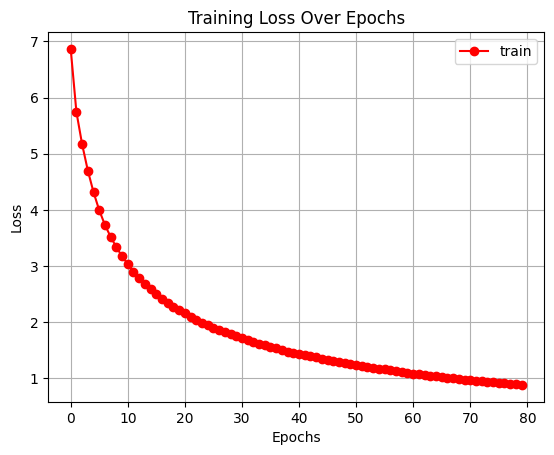

In [ ]:
# Create the plot
plt.plot(train_losses, marker='o', color='red', label='train')

# Add title and labels
plt.title('Training Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')

# Display the plot
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
def evaluate(sent) :
    sentence = src_tokenizer.texts_to_sequences([sent])
    sentence = pad_sequences(sentence , maxlen = SRC_MAXLEN , padding = 'post')

    src_input = torch.tensor(np.array(sentence) , dtype = torch.int64)

    decoder_input = trg_tokenizer.texts_to_sequences(['sos'])
    decoder_input = torch.tensor(np.array(decoder_input) , dtype = torch.int64)

    src_input , decoder_input = src_input.to(DEVICE) , decoder_input.to(DEVICE)

    for i in range(TRG_MAXLEN) :
        preds = model(src_input , decoder_input)

        preds = preds[: , -1: , :]

        predicted_id = torch.argmax(preds, dim=-1)

        if predicted_id.item() == trg_tokenizer.word_index['eos'] :
            return decoder_input.squeeze(0)

        decoder_input = torch.cat([decoder_input , predicted_id] , dim = 1)

    return decoder_input.squeeze(0)

In [ ]:
# Define the SRC_MAXLEN
SRC_MAXLEN = np.max(df['src_len'])
TRG_MAXLEN = np.max(df['trg_len'])

In [ ]:
test_sample = df.head(100)
x_test = test_sample['instruction'].tolist()
y_test = test_sample['output'].tolist()

In [ ]:
for idx , (src_sent , trg_sent) in enumerate(zip(x_test[10:] , y_test[10:])) :
    result = evaluate(src_sent)
    pred_sent = ' '.join([trg_tokenizer.index_word[idx] for idx in result.cpu().numpy() if idx != 0 and idx != 2])
    print(f"Input sentence {idx+1} : {src_sent}")
    print(f"Actual correction {idx+1} : {trg_sent}")
    print(f"Predicted correction {idx+1} : {pred_sent}\n")

Input sentence 1 : how do i find the mappings between sedol and isin codes
Actual correction 1 : <sos> you can get this information through bloomberg but it's a paid service <eos>
Predicted correction 1 : the power of the data is sqrt times

Input sentence 2 : what expenses do most people not prepare for that turn into emergencies but are not covered by an emergency fund
Actual correction 2 : <sos> here's a few is this what you're looking for also this should probably be a community wiki <eos>
Predicted correction 2 : what are some even if you can add up here's what you're looking for also be

Input sentence 3 : how do dividend reinvestment purchases work
Actual correction 3 : <sos> as far as i know it has the same price and effects on the market as any other transaction <eos>
Predicted correction 3 : the effects of climate crisis is on the same price any other organizations

Input sentence 4 : should i use a tsp loan
Actual correction 4 : <sos> never borrow money to purchase a depreci